# Eddy Detector

Term project for ESS 490/590

Grad: Erik Fredrickson

Undergrad: Ashika Capirala

*Some kind of project description can go here*

put a reminder here about the dependencies, and include an example line of how to load the environment file (should be included in our directory)

In [122]:
# imports (WILL NEED TO BE UPDATED AS WE GO!)
import random
from math import cos, sin, pi, sqrt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# keep these
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import pandas as pd
import netCDF4 as nc
from os import listdir
from IPython.display import HTML

# Import the Obspy modules that will be useful to download IRIS data
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime

## Import Data

### APG pressures and temperatures

Originally from IRIS (https://www.iris.edu/hq/; https://doi.org/10.7914/SN/XO_2018) 

#### Pressure

In [9]:
# get a list of the available files
p_file_list = listdir('data/p_daily')
p_file_list.remove(p_file_list[0])
p_file_list

['LT11.nc',
 'LA25.nc',
 'LT01.nc',
 'LA21.nc',
 'LT20.nc',
 'LT14.nc',
 'LA30.nc',
 'LT04.nc',
 'LT10.nc',
 'LA34.nc',
 'LA33.nc',
 'LT07.nc',
 'LA23.nc',
 'LT13.nc',
 'LT03.nc',
 'LT12.nc',
 'LA32.nc',
 'LT16.nc',
 'LT06.nc',
 'LA22.nc',
 'LA39.nc',
 'LA28.nc']

In [18]:
# Load just one as an example
pfile = 'data/p_daily/' + p_file_list[0]
LT01 = nc.Dataset(pfile)
LT01

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): n(1), str(4), obs(354)
    variables(dimensions): |S1 station id(str,n), float64 latitude(), float64 longitude(), float64 depth(), float64 time(obs), float64 pressure(obs)
    groups: 

Text(0.5, 1.0, 'example pressure time series')

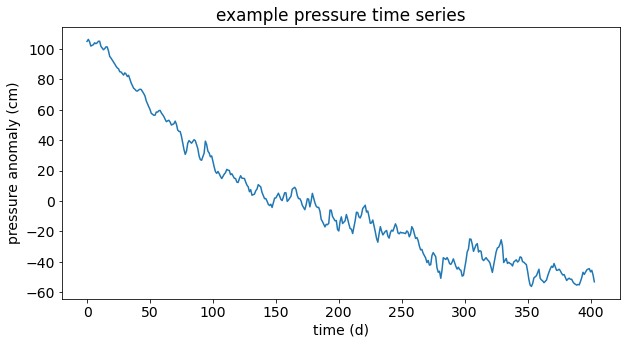

In [19]:
# make demonstrative plot
ampfac = 1/10065/0.01 # Pa to cm seawater
t = np.array(LT01['time'])
p = np.array(LT01['pressure'])

params = {'legend.fontsize': 14, \
          'xtick.labelsize':14, \
          'ytick.labelsize':14, \
          'font.size':14}
plt.rcParams.update(params)

fig1 = plt.figure(figsize=(10, 5))
ax1 = fig1.add_subplot(111)
ax1.plot(t-t[0],(p-np.mean(p))*ampfac)
ax1.set_xlabel('time (d)')
ax1.set_ylabel('pressure anomaly (cm)')
plt.title('example pressure time series')

#### Temperature

In [15]:
# get a list of the available files
T_file_list = listdir('data/T_daily')
T_file_list.remove(T_file_list[0])
T_file_list

['LT14_T.nc',
 'LT03_T.nc',
 'LT12_T.nc',
 'LT04_T.nc',
 'LT13_T.nc',
 'LT06_T.nc',
 'LT10_T.nc',
 'LA22_T.nc',
 'LA34_T.nc',
 'LA23_T.nc',
 'LA39_T.nc',
 'LT11_T.nc',
 'LT07_T.nc',
 'LT20_T.nc',
 'LA32_T.nc',
 'LT16_T.nc',
 'LT01_T.nc',
 'LA33_T.nc',
 'LA25_T.nc']

In [16]:
# Load just one as an example
Tfile = 'data/T_daily/' + T_file_list[0]
LT01_T = nc.Dataset(Tfile)
LT01_T

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): n(1), str(4), obs(400)
    variables(dimensions): |S1 station id(str,n), float64 latitude(), float64 longitude(), float64 depth(), float64 time(obs), float64 temperature(obs)
    groups: 

Text(0.5, 1.0, 'example temperature time series')

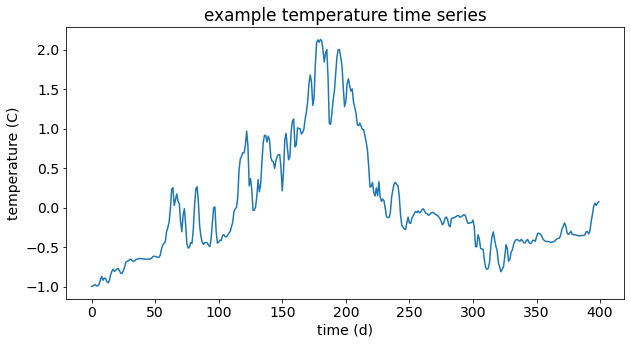

In [22]:
# make demonstrative plot
t = np.array(LT01_T['time'])
T = np.array(LT01_T['temperature'])

fig1b = plt.figure(figsize=(10, 5))
ax1b = fig1b.add_subplot(111)
ax1b.plot(t-t[0],T)
ax1b.set_xlabel('time (d)')
ax1b.set_ylabel('temperature (C)')
plt.title('example temperature time series')

### Satellite altimetry

Originally from Copernicus Marine (https://marine.copernicus.eu/; https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_CLIMATE_L4_REP_OBSERVATIONS_008_057)

In [84]:
# load from netcdf
sshfile = 'data/altimetry.nc'
SSH = nc.Dataset(sshfile)
SSH

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): y(29), x(49), t(385)
    variables(dimensions): float64 latitude(y), float64 longitude(x), float64 time(t), float64 ssh(t,y,x)
    groups: 

In [91]:
# get instrument locations and depths from pressure files
stalat = np.empty([len(p_file_list), 1])
stalon = np.empty([len(p_file_list), 1])
stadep = np.empty([len(p_file_list), 1])
for i in range(len(p_file_list)):
    temp = nc.Dataset('data/p_daily/' + p_file_list[i])
    stalat[i] = np.array(temp['latitude'])
    stalon[i] = np.array(temp['longitude'])
    stadep[i] = np.array(temp['depth'])
    
# flatten arrays (there's probably a better way to build them in the first place...)
stalat = stalat.flatten()
stalon = stalon.flatten()
stadep = stadep.flatten()
    
# stack arrays and separate into 2, one for shelf locations and one for slope locations
ishelf = stadep < 300
shelf = np.stack([stalon[ishelf],stalat[ishelf],stadep[ishelf]])
slope = np.stack([stalon[~ishelf],stalat[~ishelf],stadep[~ishelf]])

(3, 10)

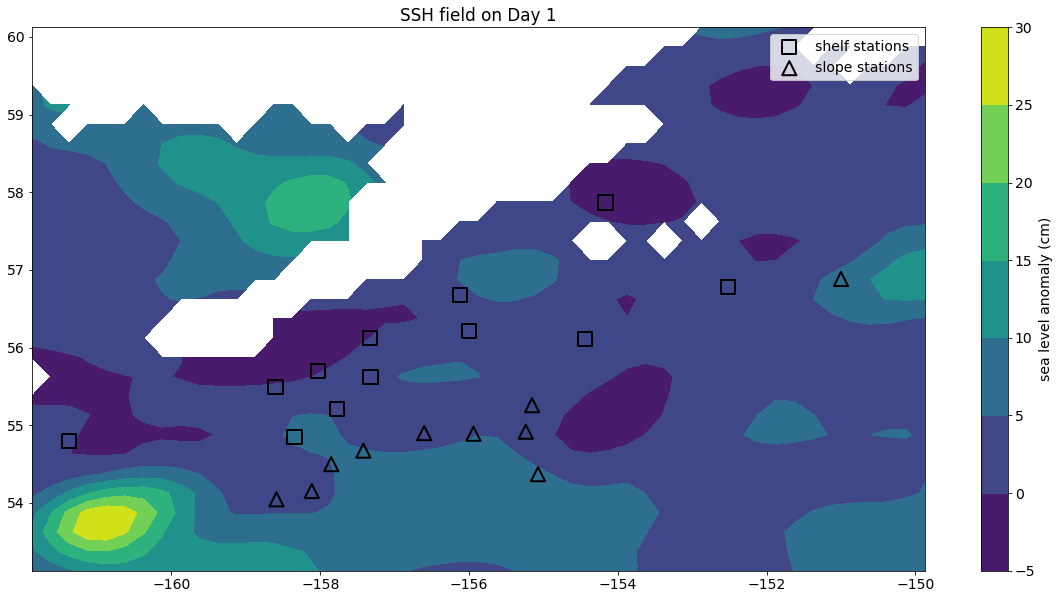

In [99]:
# make demonstrative plot
sla = np.array(SSH['ssh'])*100 # convert from m to cm
ta = np.array(SSH['time'])
x = -(360 - np.array(SSH['longitude']))
y = np.array(SSH['latitude'])
X, Y = np.meshgrid(x, y)

fig2 = plt.figure(figsize=(20, 10))
ax2 = fig2.add_subplot(111)
im = ax2.contourf(X, Y, sla[1,:,:])
ax2.scatter(shelf[0,:], shelf[1,:], marker='s', s=200, facecolors='none', edgecolors='black', linewidths=2, \
            label='shelf stations')
ax2.scatter(slope[0,:], slope[1,:], marker='^', s=200, facecolors='none', edgecolors='black', linewidths=2, \
            label='slope stations')
cb = fig2.colorbar(im)
plt.title('SSH field on Day 1')
cb.set_label('sea level anomaly (cm)')
plt.legend()

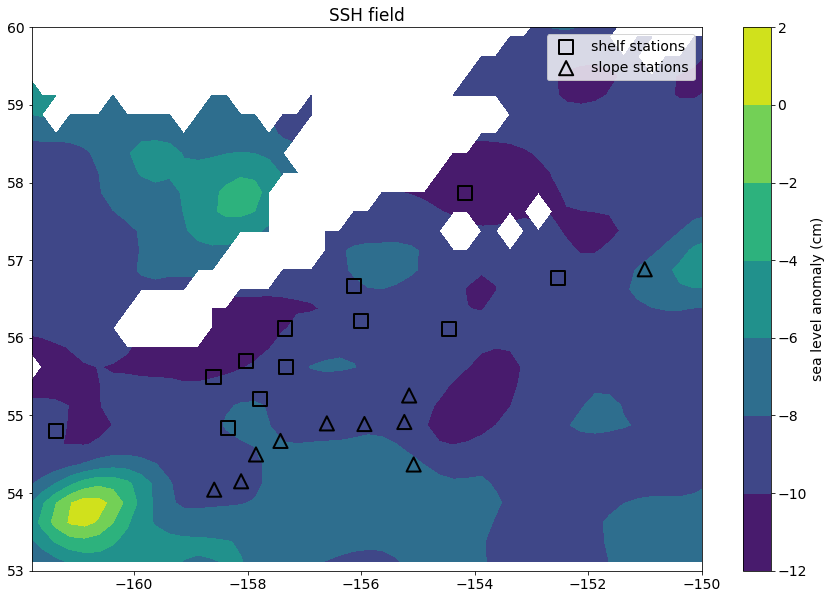

In [158]:
# Let's try to make a movie!

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(xlim=(-161.8, -150), ylim=(53, 60))
cont = [ax.contourf(X, Y, sla[1,:,:], zorder=-1)]
ax.scatter(shelf[0,:], shelf[1,:], marker='s', s=200, facecolors='none', edgecolors='black', linewidths=2, \
            label='shelf stations')
ax.scatter(slope[0,:], slope[1,:], marker='^', s=200, facecolors='none', edgecolors='black', linewidths=2, \
            label='slope stations')
cb = fig.colorbar(im)
plt.title('SSH field')
cb.set_label('sea level anomaly (cm)')
ax.legend()

# animation function.  This is called sequentially
def animate(i):
    for tp in cont[0].collections:
        tp.remove()
    cont[0] = ax.contourf(X, Y, sla[i,:,:], zorder=-1)
    return cont[0].collections

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=385, interval=100, blit=True)

# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [159]:
# HTML(anim.to_html5_video())
rc('animation', html='html5')
anim

### Oceanographic model

Model data not currently publicly available :(
Load from netcdf

In [100]:
modfile1 = 'data/CGOA_p.nc' # bottom pressure
modfile2 = 'data/CGOA_ssh.nc' # sea surface height
modfile3 = 'data/CGOA_T.nc' # bottom temperature
Pm = nc.Dataset(modfile1)
SSHm = nc.Dataset(modfile2)
Tm = nc.Dataset(modfile3)
Tm

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): y(117), x(84), t(384)
    variables(dimensions): float64 latitude(y), float64 longitude(x), float64 depth(y,x), float64 time(t), float64 temperature(t,y,x)
    groups: 

In [115]:
# exclude instrument locations outside of model domain
ibad1 = (shelf[0,:] < -160) | (shelf[0,:] > -150)
ibad2 = (slope[0,:] < -160) | (slope[0,:] > -150)
shelf_m = shelf[:,~ibad1]
slope_m = slope[:,~ibad2]

array([False, False,  True, False, False, False, False, False, False,
       False, False, False], dtype=bool)

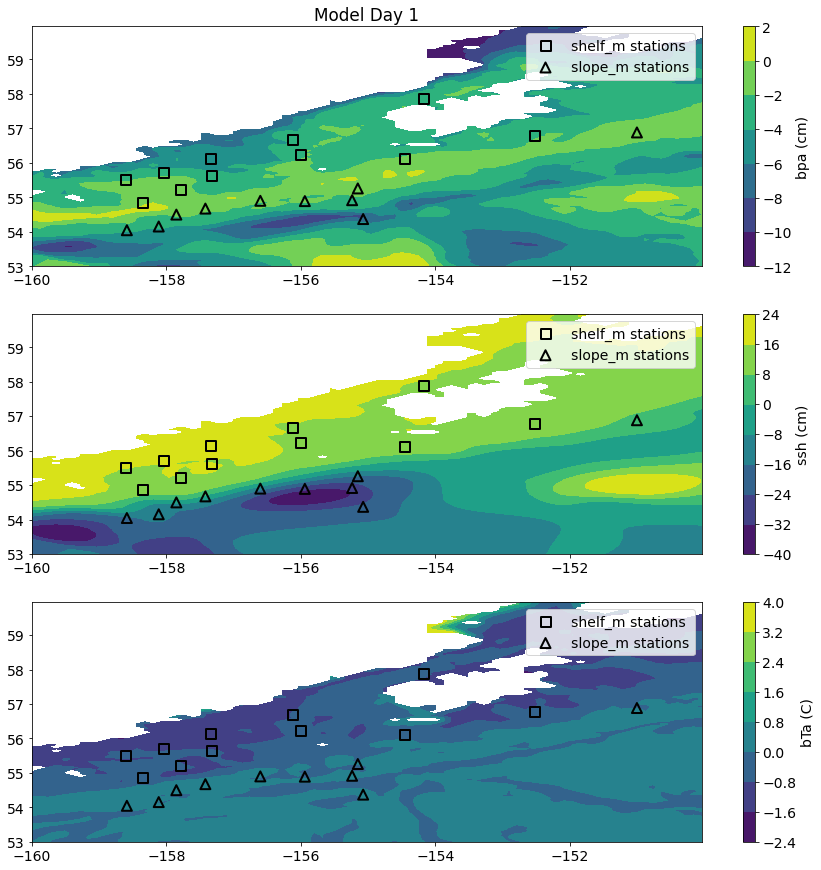

In [119]:
# make demonstrative plots
p_mod = np.array(Pm['pressure'])
ssh_mod = np.array(SSHm['ssh'])
T_mod = np.array(Tm['temperature'])
t_mod = np.array(Pm['time'])
x_mod = np.array(Pm['longitude'])
y_mod = np.array(Pm['latitude'])
Xm, Ym = np.meshgrid(x_mod, y_mod)

pa_mod = np.zeros((384,117,84))
Ta_mod = np.zeros((384,117,84))
ssha_mod = np.zeros((384,117,84))
for i in range(84):
    for j in range(117):
        pa_mod[:,j,i] = p_mod[:,j,i] - np.mean(p_mod[:,j,i])
        Ta_mod[:,j,i] = T_mod[:,j,i] - np.mean(T_mod[:,j,i])
        ssha_mod[:,j,i] = ssh_mod[:,j,i] - np.mean(ssh_mod[:,j,i])

fig3 = plt.figure(figsize=(15, 15))
ax3a = fig3.add_subplot(311)
im = ax3a.contourf(Xm, Ym, pa_mod[1,:,:]*ampfac)
ax3a.scatter(shelf_m[0,:], shelf_m[1,:], marker='s', s=100, facecolors='none', edgecolors='black', linewidths=2, \
            label='shelf_m stations')
ax3a.scatter(slope_m[0,:], slope_m[1,:], marker='^', s=100, facecolors='none', edgecolors='black', linewidths=2, \
            label='slope_m stations')
cb = fig3.colorbar(im)
plt.title('Model Day 1')
cb.set_label('bpa (cm)')
ax3a.legend()
ax3b = fig3.add_subplot(312)
imb = ax3b.contourf(Xm, Ym, ssh_mod[1,:,:]*100)
ax3b.scatter(shelf_m[0,:], shelf_m[1,:], marker='s', s=100, facecolors='none', edgecolors='black', linewidths=2, \
            label='shelf_m stations')
ax3b.scatter(slope_m[0,:], slope_m[1,:], marker='^', s=100, facecolors='none', edgecolors='black', linewidths=2, \
            label='slope_m stations')
cbb = fig3.colorbar(imb)
cbb.set_label('ssh (cm)')
ax3b.legend()
ax3c = fig3.add_subplot(313)
imc = ax3c.contourf(Xm, Ym, Ta_mod[1,:,:])
ax3c.scatter(shelf_m[0,:], shelf_m[1,:], marker='s', s=100, facecolors='none', edgecolors='black', linewidths=2, \
            label='shelf_m stations')
ax3c.scatter(slope_m[0,:], slope_m[1,:], marker='^', s=100, facecolors='none', edgecolors='black', linewidths=2, \
            label='slope_m stations')
cbc = fig3.colorbar(imc)
cbc.set_label('bTa (C)')
ax3c.legend()

Text(0.5, 1.0, 'example pressure time series')

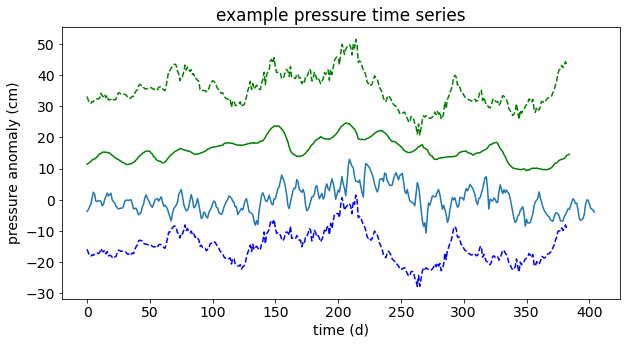

In [74]:
# plot time series on same axes
fig4 = plt.figure(figsize=(10, 5))
ax4 = fig4.add_subplot(111)
ax4.plot(t-t[0],(p-np.mean(p))*ampfac)
ax4.plot(ta-ta[0], sla[:,15,38] + 10, color='green')
ax4.plot(t_mod-t_mod[0], pa_mod[:,63,64]*ampfac - 15, color='blue', linestyle='dashed')
ax4.plot(t_mod-t_mod[0], ssh_mod[:,63,64]*100 + 20, color='green', linestyle='dashed')
ax4.set_xlabel('time (d)')
ax4.set_ylabel('pressure anomaly (cm)')
plt.title('example pressure time series')

## Training Data (maybe)

### Eddy presence/absence

<img src="eddy_field.jpg" width="600">
<center>https://doi.org/10.1175/JTECH-D-14-00019.1</center>